# Investigating High Traffic Indicators on Westbound I-94

## 1. Introduction

Interstate 94 (I-94) is a vital highway traversing the American Midwest, stretching **1,585 miles** from Billings, Montana, to Port Huron, Michigan. A significant segment of this highway—between **Minneapolis and St. Paul**—is known for its heavy traffic volume. The insights gleaned from this investigation hold the potential to drive tangible improvements in roadway efficiency and safety.

### 1.1 Objective

This project investigates patterns in traffic volume along **westbound I-94** using hourly data collected between **2012 and 2018**. The analysis focuses on identifying which factors most strongly influence heavy traffic conditions. 

---

### 1.2 Stakeholders

- **Transportation agencies** seeking data-driven strategies for traffic mitigation.
- **Urban planners** aiming to improve infrastructure planning.
- **Logistics companies** looking to optimize delivery routes.
- **Daily commuters** hoping to avoid peak congestion.

---

### 1.3 Use Case

By uncovering patterns related to traffic volume, this analysis can:
- Predict periods of high traffic.
- Identify the impact of **weather**, **holidays**, **temperature**, and **time of day**.
- Enable more efficient **resource allocation**, **infrastructure investment**, and **personal travel planning**.

---

### 1.4 Why Focus on I-94?

Several factors make this corridor an ideal candidate for analysis:

- **Strategic Connectivity**: Connects major Midwestern cities such as the bustling metropolises of Minneapolis-St. Paul, Milwaukee, and Chicago.
- **Economic Significance**: Facilitates the movement of high-volume freight and goods, fueling economic activity. Understanding traffic dynamics is essential for optimizing logistical operations.
- **Congestion Hotspot**: Particularly along the westbound route from Minneapolis to St. Paul which is notorious for high traffic volume.

## 2. Dataset Overview and Initial Exploration

We use the [Metro Interstate Traffic Volume dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume), published by John Hogue in the **UCI Machine Learning Repository**. It includes hourly traffic data from 2012-2018, collected via an automatic sensor along I-94.

This dataset focuses exclusively on **westbound traffic from Minneapolis to St. Paul** segment of the I-94 which is renowned for its high traffic congestion, ensuring relevant and actionable insights without generalization.


<center>
  <img src="../images/i94_map.jpg" alt="Map of I-94 between Minneapolis and St. Paul" width="500" height="300">
</center>

<center>
    <i>Figure 1: Map showing the analyzed segment of I-94.</i>
</center>

We'll begin by importing the dataset and the relevant libraries for the project.

In [4]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from numpy import std

In [5]:
sns.set()

# Define color palettes
warm_tones = ['#f4a261', '#264653', '#2a9d8f', '#1d3557', '#e76f51', '#e63946', '#A0432F']

# Set global matplotlib defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['legend.edgecolor'] = 'white'

# Set Seaborn style and spine formatting
sns.set_style("white", {"axes.spines.right": False, "axes.spines.top": False, 
                        "axes.spines.left": True,"axes.spines.bottom": True})

plt.rcParams['axes.edgecolor'] = '#444444'

Next, we preview the dataset to get a first look at the data and assess any immediate cleaning steps or formatting issues that need to be addressed.

In [7]:
# Load the dataset
i94_traffic = pd.read_csv("../data/Metro_Interstate_Traffic_Volume.csv", encoding="latin1")

# Preview the first and last few rows
display(i94_traffic.head(3))
display(i94_traffic.tail(3))

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [8]:
# Check data types and missing values
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


### 2.1 Initial Observations:
The dataset includes the following columns:

| Column Name           | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `date_time`            | Timestamp of data record (hourly granularity)                              |
| `holiday`              | Name of U.S. holiday (if any)                  |
| `temp`                 | Temperature in Kelvin                                                      |
| `rain_1h`              | Rainfall amount in mm during the past hour                                 |
| `snow_1h`              | Snowfall amount in mm during the past hour                                 |
| `clouds_all`           | Cloud coverage in percentage (0–100%)                                      |
| `weather_main`         | Broad weather category (e.g., Clear, Rain, Snow)                           |
| `weather_description`  | More detailed description of the weather condition (e.g., light rain, heavy snow) |
| `traffic_volume`       | Number of cars that passed the sensor during that hour                     |



📄*Note: The weather-related features (`clouds_all`, `weather_main`, `weather_description`) come from OpenWeatherMap APIs and provide insight into how varying weather conditions may influence `traffic volume`. The `traffic_volume` field is our target variable.*

💡 **Key Takeaways:**

- **Dataset Dimensions:** The dataset includes **48,204** entries and **9** columns.

- **Date Format:** The `date_time` column will need to be converted to datetime format for time-based analysis.

- **Missing Data:** The `holiday` column appears to have missing values, though the dataset documentation suggests otherwise. Further investigation into this discrepancy is warranted to identify the underlying issue and address it accordingly.

In [12]:
# Investigate the 'holiday' column
i94_traffic['holiday'].value_counts(dropna=False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

It appears that **48,143** entries are marked as `NaN`, which likely results from pandas interpreting the string `"None"` as missing during import. A quick check in Excel confirmed that the original CSV uses `"None"` to denote non-holiday dates.

## 3. Data Cleaning and Preparation
Before conducting any analysis, it's essential to ensure the data is clean and well-structured. We'll perform the following preprocessing tasks:

1. Replace missing values in the `holiday` column.
2. Convert the `date_time` column to datetime format.
3. Review and clean the categorical columns.
4. Check numerical columns for potential outliers.

### 3.1 Replace Missing Values in `holiday`

In [16]:
# Investigate the holiday column
i94_traffic['holiday'].value_counts(dropna=False)

holiday
NaN                          48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

It appears that **48,143** entries are marked as `NaN`, likely due to  pandas interpreting the string **"None"** as missing during import. A quick inspection in Excel confirms that the original CSV uses "None" (as a string) to indicate non-holiday dates.

To restore the intended values, we’ll replace all missing entries in this column with the string "None".

In [18]:
# Replace missing values in the holiday column with "None"
i94_traffic['holiday'] = i94_traffic['holiday'].fillna("None")

# Confirm changes
i94_traffic['holiday'].isnull().sum()

0

*Result: All 48,204 entries in the `holiday` column are now non-null.*


### 3.2 Convert `date_time` to Datetime Format

In [21]:
# Convert the 'date_time' column from object to datetime
i94_traffic['date_time'] = pd.to_datetime(i94_traffic['date_time'])

# Confirm the change
i94_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


*Result: The `date_time` column is now a datetime object, enabling time-based analysis.*

### 3.3 Review Categorical Columns

We'll inspect the key categorical variables for unexpected or inconsistent values.

In [24]:
# Distribution of high-level weather categories
i94_traffic['weather_main'].value_counts(normalize=True) * 100

weather_main
Clouds          31.457970
Clear           27.779852
Mist            12.343374
Rain            11.766658
Snow             5.966310
Drizzle          3.777695
Haze             2.821343
Thunderstorm     2.145050
Fog              1.891959
Smoke            0.041490
Squall           0.008298
Name: proportion, dtype: float64

In [25]:
# Inspect detailed weather descriptions
i94_traffic['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

We'll standardize the `weather_description` column by converting all entries to lowercase:

In [27]:
i94_traffic['weather_description'] = i94_traffic['weather_description'].str.lower()

📄*Note: We may later extract severity or types from the descriptions, but this step is postponed until we determine its relevance.*

### 3.4 Check for Outliers in Numerical Columns

We'll begin with `rain_1h`, where an extreme outlier was detected:

In [30]:
# Check the rain column value ranges
percentages = i94_traffic['rain_1h'].value_counts(bins = 10, normalize=True) * 100
percentages.sort_index()

(-9.831999999999999, 983.13]    99.997925
(983.13, 1966.26]                0.000000
(1966.26, 2949.39]               0.000000
(2949.39, 3932.52]               0.000000
(3932.52, 4915.65]               0.000000
(4915.65, 5898.78]               0.000000
(5898.78, 6881.91]               0.000000
(6881.91, 7865.04]               0.000000
(7865.04, 8848.17]               0.000000
(8848.17, 9831.3]                0.002075
Name: proportion, dtype: float64

**Identify Outlier**

A quick binning of `rain_1h` reveals that **99.99%** of entries fall under **983 mm**, yet one record exceeds **9,800 mm**. To understand how extreme this value is, we’ll calculate its **z-score**:

In [32]:
# Identify extreme values in rain_1h
i94_traffic['rain_1h'].describe()

# Calculate z-score for values greater than 1000 mm
from scipy.stats import zscore

outlier_value = i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'].iloc[0]
z = zscore(i94_traffic['rain_1h'].fillna(0))
z_value = z[i94_traffic['rain_1h'] > 1000]

# Display outlier details
print(f"Z-score of outlier: {z_value[z_value.index[0]]:.1f}")
print(f"Outlier value: {i94_traffic['rain_1h'].max():.1f}")

Z-score of outlier: 219.5
Outlier value: 9831.3


The entry at index 24872 recorded **9831.3 mm** of rainfall in a single hour i.e. **~219.5 standard deviations** above the mean. This is implausible and likely a data entry or sensor error.

**Correct the Outlier**

We’ll treat this value as invalid and replace it with 0.0, assuming it reflects no rain:

In [35]:
# Correct invalid rainfall value
i94_traffic.loc[i94_traffic['rain_1h'] > 1000, 'rain_1h'] = 0.0

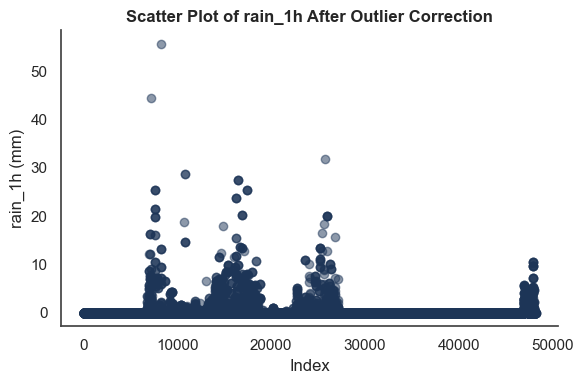

In [36]:
# Scatter plot after correction
plt.scatter(x=range(len(i94_traffic)), y=i94_traffic['rain_1h'], alpha=0.5, color=warm_tones[3])

plt.title('Scatter Plot of rain_1h After Outlier Correction', fontweight='bold')
plt.xlabel('Index')
plt.ylabel('rain_1h (mm)')
plt.show()

After correction, the distribution appears far more realistic and reflects true variability.

**Other Numerical Columns**

We also reviewed other numerical columns:

- `snow_1h`

- `clouds_all`

- `temp`

- `traffic_volume`

No major irregularities or implausible values were found. For brevity, their checks are not shown here.

## 4. Pre-Processing

### 4.1 Exploring Traffic Volume Distribution
Let’s begin by understanding how traffic volume is distributed over time:

In [41]:
# Calculate Key Stats
traffic_vol = i94_traffic['traffic_volume']
mean = traffic_vol.mean()
st_dev = traffic_vol.std(ddof=0)

traffic_vol.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

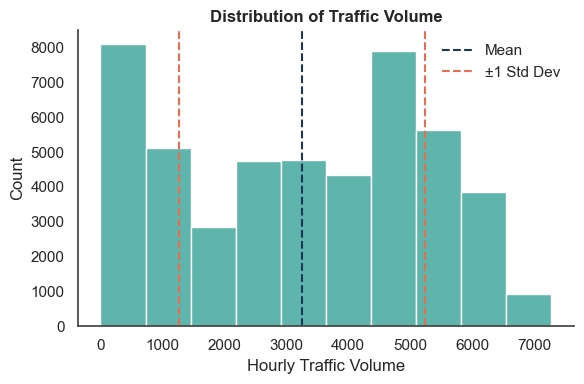

In [42]:
# Histogram of traffic volume with mean and standard deviation lines
sns.histplot(x=traffic_vol, bins=10, color=warm_tones[2])

plt.axvline(mean, color=warm_tones[3], linestyle='--', label='Mean')
plt.axvline(mean + st_dev, color=warm_tones[4], linestyle='--', label='±1 Std Dev')
plt.axvline(mean - st_dev, color=warm_tones[4], linestyle='--')

plt.title('Distribution of Traffic Volume', fontweight = 'bold')
plt.xlabel('Hourly Traffic Volume')
plt.legend()
plt.show()

💡 **Key Insights:**

- Between 2012 and 2018, hourly traffic volume ranged from **0 to 7,280** vehicles.

- Two distinct peaks appear: around **0–500** vehicles and **4,500–5,000** vehicles—each with approximately **8,000** entries.

- The **average** hourly volume is about **3,260** vehicles.

- **25% of the time**, traffic volume was at or below 1,193 vehicles, likely representing nighttime periods.

- **75% of the time**, traffic remained under 4,933 vehicles per hour. The remaining 25% likely represent daytime congestion.

*These patterns suggest a clear contrast between high and low traffic periods, hinting at a **strong temporal influence**, which we’ll explore next.*

### 4.2 Segmenting Traffic Data by Time of Day
To enable a more focused analysis, we segmented the dataset into two 12-hour intervals based on time of day:

- **Daytime**: 7:00 a.m. to 7:00 p.m.

- **Nighttime**: 7:00 p.m. to 7:00 a.m.

📄 *Note: The `date_time` column was formatted during the data cleaning phase to support time-based analysis.*

In [45]:
date_col = i94_traffic['date_time']

# Create boolean masks for time segmentation
daytime_bool = (date_col.dt.time >= dt.time(7, 0, 0)) & (date_col.dt.time < dt.time(19, 0, 0))
nighttime_bool = (date_col.dt.time >= dt.time(19, 0, 0)) | (date_col.dt.time < dt.time(7, 0, 0))

# Label time of day
i94_traffic['time_of_day'] = ''
i94_traffic.loc[daytime_bool, 'time_of_day'] = 'Daytime'
i94_traffic.loc[nighttime_bool, 'time_of_day'] = 'Nighttime'

### 4.3 Visualizing Daytime vs. Nighttime Traffic Distributions

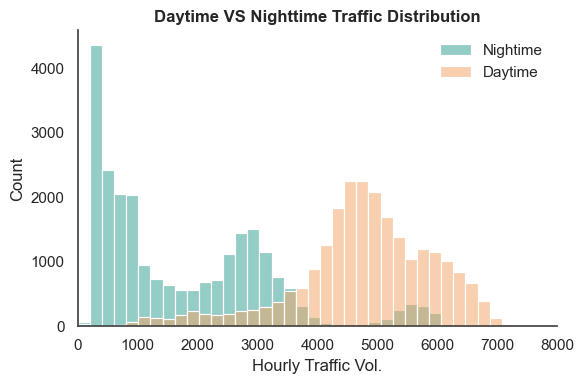

In [47]:
# Create a color map for daytime and nightime traffic
color_map = {'Daytime': warm_tones[0], 'Nighttime': warm_tones[2]}

# Compare the distribution between daytime vs nightime traffic
sns.histplot(data=i94_traffic, x="traffic_volume", hue="time_of_day", palette=color_map, legend=False)

plt.legend(labels=['Nightime', 'Daytime'], loc='upper right')
plt.title('Daytime VS Nighttime Traffic Distribution', fontweight='bold')
plt.xlabel('Hourly Traffic Vol.')
plt.ylabel('Count')
plt.xlim(0, 8000)

plt.show()

In [48]:
# Get descriptive stats
day_stats = i94_traffic.loc[daytime_bool, 'traffic_volume'].describe()
night_stats = i94_traffic.loc[nighttime_bool, 'traffic_volume'].describe()

# Combine into one DataFrame
combined_stats = pd.concat([day_stats, night_stats], axis=1)
combined_stats.columns = ['Daytime Traffic', 'Nighttime Traffic']

# Display the stats
combined_stats

,Daytime Traffic,Nighttime Traffic
count,23877.000000,24327.000000
mean,4762.047452,1785.377441
std,1174.546482,1441.951197
min,0.000000,0.000000
25%,4252.000000,530.000000
50%,4820.000000,1287.000000
75%,5559.000000,2819.000000
max,7280.000000,6386.000000


💡 **Key Insights:**

- **Nighttime Traffic:** Right-skewed distribution with 75% of hourly volumes ≤ 2,819. Range: 0 to 6,386 vehicles.

- **Daytime Traffic:** Roughly normal distribution, with 50% of volumes > 4,820 and a substantial concentration between 4,500 and 5,000. Range: 0 to 7,280 vehicles, notably larger than nighttime volumes.

Given our goal of identifying high-traffic indicators, the daytime distribution offers a richer basis for further exploration. Therefore, we will proceed with an isolated analysis of the daytime traffic subset.

In [50]:
daytime_traffic = i94_traffic.copy().loc[daytime_bool]

<!-- # 5. EDA: Exploring Traffic Patterns -->
With the data preprocessed, we are ready to further analyze the daytime traffic patterns and it's behavior across time and other factors to uncover meaningful trends.

We’ll focus on: 

- Analyze traffic volume across different time windows (hour, day, month) and conditions (daytime vs. nighttime, weekday vs. weekend).
- Other Factors
- Investigate how weather, holidays, and temperature relate to traffic volume.

## 5. Temporal Traffic Analysis
We now examine how traffic volume varies across different time dimensions:

1. **Month:** Seasonal and monthly traffic fluctuations.

2. **Day of the Week:** Weekly traffic trends.

3. **Hourly Patterns (Weekday vs. Weekend):** Comparative hourly flows between weekdays and weekends.

We'll begin with a reusable function for grouping and visualization.

In [53]:
def group_and_visualize(col_name, dataset, ax=None):
    # Compute average traffic volume for each unique value in the specified column
    mean_by_col = dataset.pivot_table(values='traffic_volume', index=col_name, aggfunc='mean')

    # Plot on the given axis if provided, otherwise use the current one
    if ax is None:
        mean_by_col['traffic_volume'].plot.line(color=warm_tones[2])
        plt.axhline(dataset['traffic_volume'].mean(), label='Mean', color=warm_tones[5], linestyle='--')
        plt.ylabel('Traffic Volume')
        plt.legend(labels=['Traffic Volume', 'Mean'], loc='lower left')
    else:
        mean_by_col['traffic_volume'].plot.line(color=warm_tones[2], ax=ax, legend=False)
        ax.axhline(dataset['traffic_volume'].mean(), label='Mean', color=warm_tones[5], linestyle='--')
        ax.set_ylabel('Traffic Volume')
        ax.legend(labels=['Traffic Volume', 'Mean'], loc='lower left')

    return mean_by_col


### 5.1 Monthly Trends

We'll start by extracting the month from the `date_time` column. We'll then group the dataset by month and calculate the avaerage for each month. Finally, we'll visualize by plotting a line chart.

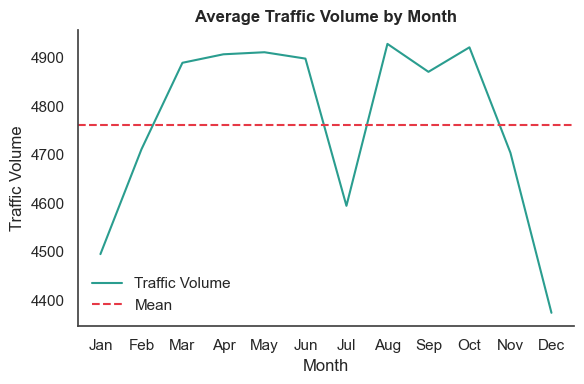

In [55]:
# Extract the month from date_time column
daytime_traffic['month'] = daytime_traffic['date_time'].dt.month

# Visualize monthly average traffic
mean_by_month = group_and_visualize('month', daytime_traffic)

plt.title('Average Traffic Volume by Month', fontweight='bold')
plt.xlabel('Month')
plt.xticks(mean_by_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

💡 **Key Insights:**

- **Winter Months (Nov–Feb):** Lower traffic, with December being the lowest.

- **Warmer Months (Mar–Oct):** Higher traffic overall, except July, which shows a noticeable dip.

**Investigating the July Traffic Plunge:**

This divergence prompts further investigation into potential contributing factors. To gain deeper insights, we'll plot yearly traffic trends in July.

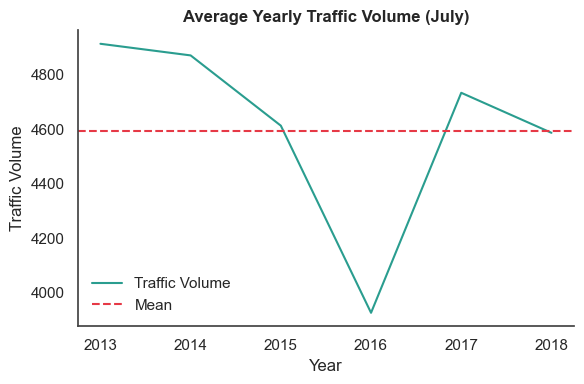

In [58]:
# Extract the year from 'date_time' column
daytime_traffic['year'] = daytime_traffic['date_time'].dt.year

# Extract July traffic data
july_traffic = daytime_traffic[daytime_traffic['month'] == 7]

# Visualize the yearly July trends
group_and_visualize('year', july_traffic)

plt.title('Average Yearly Traffic Volume (July)', fontweight='bold')
plt.xlabel('Year')
plt.show()

Clearly, July 2016 is an expection. We'll investigate the warmer months excluding this value.

In [60]:
from math import ceil

# Isolate the data for warmer months
warmer_months = daytime_traffic[daytime_traffic['month'].between(3, 10)]

# Create Boolean mask for July, 2016
july_2016_bool = (warmer_months['year'] == 2016) & (warmer_months['month'] == 7)

# Exclude July, 2016 data from the warmer months data
ceil(warmer_months.loc[~july_2016_bool, 'traffic_volume'].mean())

4883

💡 **Observation:** 

The dip in **July 2016** skews the average. This anomaly could be due to external disruptions (e.g., construction). After excluding this outlier, the warm months show average traffic volumes near **4,883 vehicles/hour**. In general, warm months exhibit heavier traffic compared to colder months.

### 5.2 Day of the Week Trends

To understand how traffic volume fluctuates throughout the week, we’ll examine the average volume per day from Monday through Sunday. This can help identify whether weekdays are generally busier than weekends and which days experience the highest or lowest volumes.

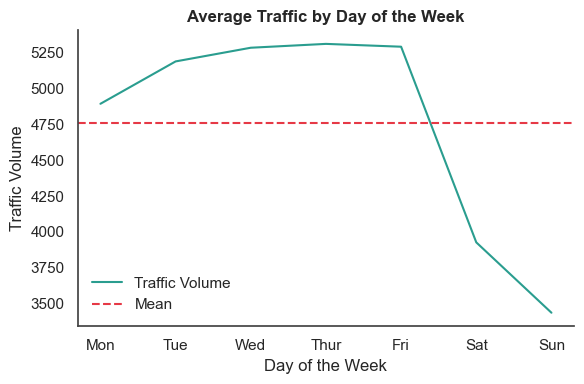

In [63]:
# Extract the day of the week from the date_time column
daytime_traffic['dayofweek'] = daytime_traffic['date_time'].dt.dayofweek

# Group by day of the week and visualize the average traffic volume
mean_by_dayofweek = group_and_visualize('dayofweek', daytime_traffic)

plt.xticks(mean_by_dayofweek.index, ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.title('Average Traffic by Day of the Week', fontweight='bold')
plt.xlabel('Day of the Week')
plt.show()

💡 **Key Insights:**

- **Weekdays (Mon–Fri):** Consistently high traffic, peaking on Friday.

- **Weekends (Sat–Sun):** Marked decline, with volumes consistently below 4,000 (lower than the average 4,762 vechicles per hour).

### 5.3 Comparing Hourly Traffic Trends: Weekdays vs. Weekends

Now that we’ve seen the traffic pattern across days, we’ll explore how traffic volume changes by hour of the day, separately for:
- **Business days (Monday–Friday)**
- **Weekends (Saturday & Sunday)**

This separation ensures weekday work commute patterns don’t obscure weekend leisure trends.

In [66]:
# Add a column to label whether the date is a weekday or weekend
daytime_traffic['day_type'] = daytime_traffic['date_time'].dt.dayofweek.apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

# Extract the hour from the date_time column
daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

# Create two subsets: one for weekdays, one for weekends
day_type_bool = daytime_traffic['day_type'] == 'Weekday'
weekend_traffic = daytime_traffic[~day_type_bool]['traffic_volume']
weekdays_traffic = daytime_traffic[day_type_bool]['traffic_volume']

**Plotting Hourly Trends Side-by-Side**

We’ll now create a two-panel line chart to show the difference in traffic volume by hour on weekdays versus weekends.

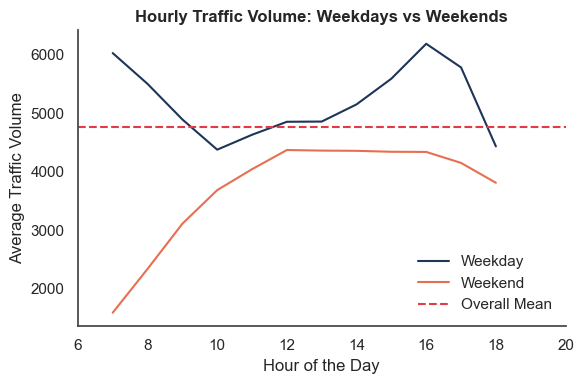

In [68]:
# Group by hour and day_type, then calculate the mean traffic volume
grouped_hourly = daytime_traffic.groupby(['hour', 'day_type'])['traffic_volume'].mean().reset_index()

# Plot using seaborn
sns.lineplot(data=grouped_hourly, x='hour', y='traffic_volume', hue='day_type', palette=[warm_tones[3], warm_tones[4]])
plt.axhline(daytime_traffic['traffic_volume'].mean(), color=warm_tones[5], linestyle='--', label='Overall Mean')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Volume')
plt.title('Hourly Traffic Volume: Weekdays vs Weekends', fontweight='bold')
plt.xlim(6, 20)  # Focus on busy hours
plt.legend()
plt.show()

We can also print out summary statistics for both traffic trends to compare average levels.

In [70]:
# Store the descriptive stats for weekday and weekend traffic into a DataFrame
descriptive_stats = pd.DataFrame()
descriptive_stats['Weekdays Traffic'] = weekdays_traffic.describe()
descriptive_stats['Weekend Traffic'] = weekend_traffic.describe()

# Display
descriptive_stats

,Weekdays Traffic,Weekend Traffic
count,17085.000000,6792.000000
mean,5191.510272,3681.751178
std,891.350321,1104.692502
min,478.000000,0.000000
25%,4652.000000,3093.750000
50%,5141.000000,3999.000000
75%,5855.000000,4468.000000
max,7280.000000,6645.000000


**Insights:**

**Business Days:**

- Consistently high traffic with peak traffic at **6 AM and 4 PM**, reflecting morning and evening commute patterns.
- Lull during late morning to early afternoon (10 AM to 2 PM).
- Average hourly volume: **~5,193 vehicles.**

**Weekends:**

- Consistent midday peak (12 PM–4 PM).
- Maintains relatively constant levels throughout the day.
- Lower traffic in early mornings (6 AM–10 AM).
- Relatively lower average hourly volume: **~3,709 vehicles.**

## 6. Exploring the Relationship Between Traffic Volume and Weather Conditions

Our dataset contains detailed weather conditions (like `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, and `weather_description`). We’ll explore how weather indicators influence traffic volume:

- Numeric weather features (e.g., temperature, rainfall)
- Categorical weather indicators (e.g., weather type and description)

### 6.1 Pearson’s Correlation: Traffic Volume vs. Numerical Weather Variables

We'll begin by calculating **Pearson’s correlation coefficients** to see if variables like temperature, rain, or cloud cover are linearly associated with traffic volume.

In [74]:
# Extract numerical weather-related columns
weather_traffic = daytime_traffic[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']]

# Compute correlation between traffic_volume and weather-related features
weather_corr = weather_traffic.corr()['traffic_volume'].sort_values(ascending=False)

# Display correlation values
weather_corr

traffic_volume    1.000000
temp              0.128317
snow_1h           0.001265
clouds_all       -0.032932
rain_1h          -0.040631
Name: traffic_volume, dtype: float64

💡 **Key Insight**: 

None of the numerical weather variables exhibit a strong correlation with traffic volume. **Temperature** has a slight positive correlation (`+0.13`) but is not strong enough to serve as a reliable indicator.


### 6.2 Visualizing Temperature vs. Traffic Volume (with Weather Overlay)

Let’s visualize how traffic volume varies with temperature, and use color (`hue`) to explore whether the type of weather (`weather_main`) plays a role.

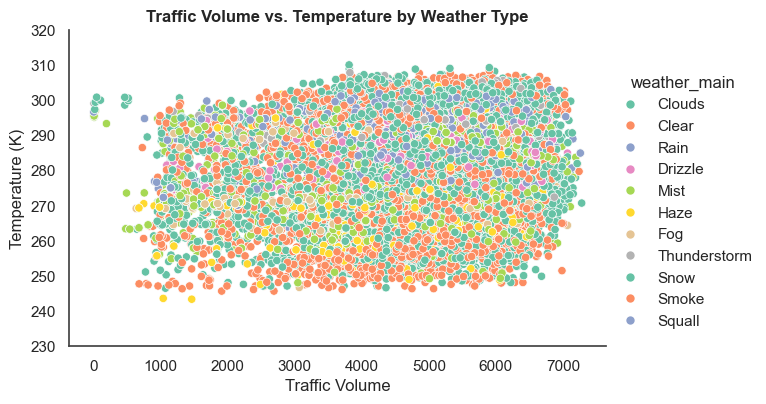

In [77]:
# Scatterplot to assess temp vs. traffic volume across different weather types
sns.relplot(data=daytime_traffic, x="traffic_volume", y="temp", hue='weather_main', palette='Set2', height=4, aspect=1.6)

plt.xlabel('Traffic Volume')
plt.ylabel('Temperature (K)')
plt.ylim(230, 320)  # Reasonable temperature range in Kelvin
plt.title('Traffic Volume vs. Temperature by Weather Type', fontweight='bold')
plt.show()

💡 **Key Insight**: 

There is no visible trend showing that higher or lower temperatures influence traffic volume in a meaningful way. Weather types do not show clear groupings either.

### 6.3 Traffic Spread Across Weather Types

This visualization lets us see the spread of traffic volume across high-level weather types.

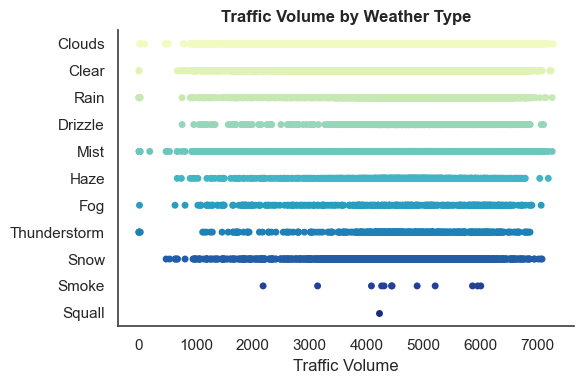

In [80]:
# Strip plot: traffic volume by general weather category
sns.stripplot(data=daytime_traffic, x='traffic_volume', y='weather_main',
              jitter=False, palette='YlGnBu', hue='weather_main', legend=False)

plt.title('Traffic Volume by Weather Type', fontweight='bold')
plt.xlabel('Traffic Volume')
plt.ylabel('')
plt.show()

💡 **Key Insight:**

Most weather types overlap in traffic volume distribution. Rare categories like *Smoke* and *Squall* have few data points and aren’t reliable indicators.


### 6.4 Top 10 Weather Descriptions by Avg. Traffic Volume

To dig deeper, we analyze the more detailed `weather_description` field to find which conditions are associated with the highest traffic volumes.

In [83]:
# Group by weather_description and calculate average traffic volume
mean_by_weather_desc = daytime_traffic.pivot_table(values='traffic_volume', index='weather_description', aggfunc='mean')

# Top 10 descriptions with highest traffic
top_10_weather = mean_by_weather_desc['traffic_volume'].sort_values(ascending=False).head(10)

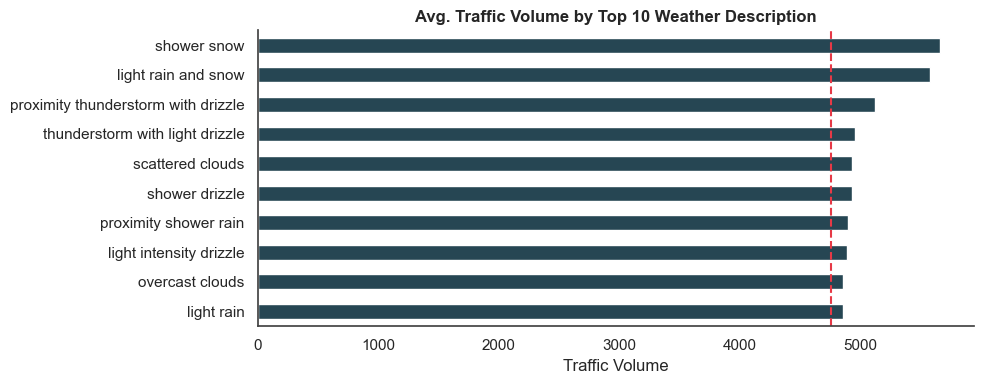

In [84]:
# Horizontal bar plot
plt.figure(figsize=(10, 4))
top_10_weather.sort_values().plot.barh(color=warm_tones[1])
plt.axvline(daytime_traffic['traffic_volume'].mean(), color=warm_tones[5], linestyle='--', label='Overall Mean')

plt.title('Avg. Traffic Volume by Top 10 Weather Description', fontweight='bold')
plt.xlabel('Traffic Volume')
plt.ylabel('')
plt.legend('')
plt.show()

💡 **Key Insight**: 

Surprisingly, conditions like *Shower snow*, *Light rain and snow*, and *Proximity thunderstorm with drizzle* show higher than average traffic volumes. This suggests that **mildly adverse** conditions don’t deter drivers..


## 7. Evaluating Traffic Trends During U.S. Holidays

In this section, we explore how U.S. holidays affect traffic volume. Holidays can lead to deviations from regular traffic patterns due to changes in commuter behavior, travel plans, and special events. We will dive into specific holidays to assess which days tend to see higher or lower traffic.


In [87]:
# Create a boolean mask to select rows with actual holidays
holiday_bool = ~(i94_traffic['holiday'] == 'None')

# Filter the dataset to include only holidays
holiday_traffic = i94_traffic[holiday_bool]

### 7.1 Average Traffic Volume for Each U.S. Holiday

We now examine the average traffic volume for each individual U.S. holiday by grouping the data and visualizing the results in a horizontal bar chart.

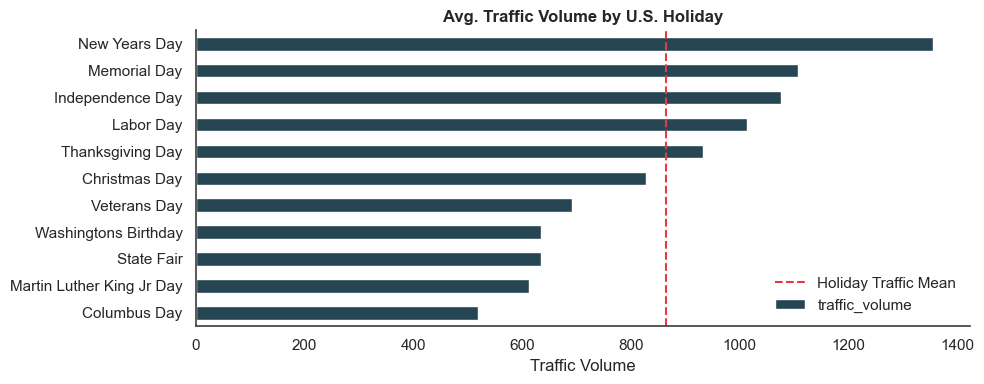

In [89]:
# Group data by holiday and calculate mean traffic volume
mean_by_holidays = holiday_traffic.pivot_table(values='traffic_volume', index='holiday', aggfunc='mean')

# Plot a bar chart showing average traffic for each holiday
plt.figure(figsize=(10, 4))
mean_by_holidays['traffic_volume'].sort_values().plot.barh(color=warm_tones[1])

plt.title('Avg. Traffic Volume by U.S. Holiday', fontweight='bold')
plt.xlabel('Traffic Volume')
plt.ylabel('')
plt.axvline(holiday_traffic['traffic_volume'].mean(), color=warm_tones[5], linestyle='--', label='Holiday Traffic Mean')
plt.legend()
plt.show()

### 7.2 Distribution of Traffic Volume Across Holidays

Next, we explore how traffic volume is distributed across each holiday. Boxplots help us see the spread, median, and any potential outliers.

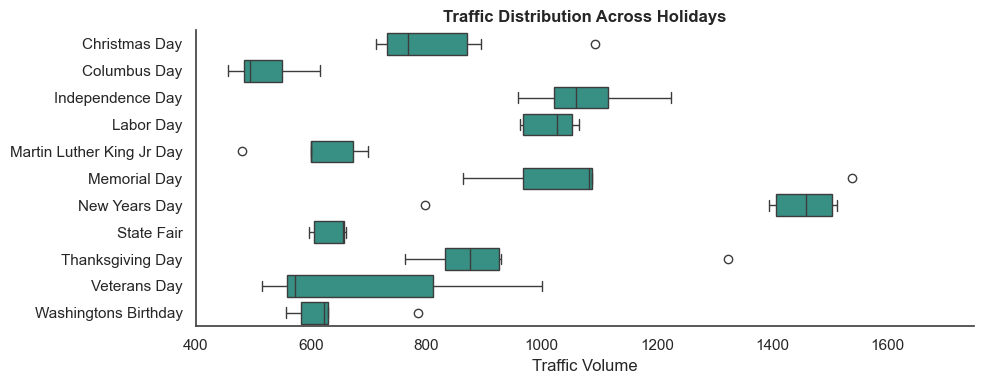

In [91]:
# Compare traffic distributions across holiday categories
plt.figure(figsize=(10, 4))
sns.boxplot(x='traffic_volume', y='holiday', data=holiday_traffic.sort_values('holiday'),
            color=warm_tones[2])

plt.title('Traffic Distribution Across Holidays', fontweight='bold')
plt.xlabel('Traffic Volume')
plt.ylabel('')
plt.xlim(400, 1750)

# Remove the default legend to avoid duplication
plt.legend([], [], frameon=False)
plt.show()

### 💡Observations & Insights

- **Holiday traffic** is generally **lower than non-holiday traffic**, likely due to fewer commuters.
- **New Year's Day** stands out with the **highest average traffic**, possibly due to post-celebration travel or early morning movement.
- **Memorial Day** and **Independence Day** follow closely, consistent with their popularity as travel-heavy holidays.
- **Thanksgiving** and **Christmas**, surprisingly, show **milder traffic volumes**, possibly because families gather in advance or stay put.
- **Boxplots** reveal that some holidays (e.g., New Year’s) consistently see high traffic with fewer extreme outliers, while others (e.g., Memorial Day) show more variability.


# 8. Conclusion
---

### 8.1 Time-Based Indicators

- **Daytime traffic** consistently exceeds nighttime traffic, especially between **4,500–5,000 vehicles per hour** during peak hours.
- **Traffic volumes peak during warmer months** (March–October) and decline in colder months (December–February).
- On **weekdays**, traffic is significantly higher, with **morning (6 AM)** and **evening (5 PM)** rush hour peaks—especially on **Fridays**.
- **Weekend traffic** behaves differently, peaking **midday (12 PM to 4 PM)** and maintaining a relatively steady volume throughout the day.

---

### 8.2 Weather Indicators

- Weather variables such as temperature and precipitation show **weak correlations** with traffic volume overall.
- However, some specific weather types—like **Shower snow**, **Light rain and snow**, and **Proximity thunderstorm with drizzle**—are associated with **surprisingly high traffic averages (above 5,000 vehicles/hour)**. These weather events, while adverse, may not significantly deter motorists.

---

### 8.3 Holiday Traffic Patterns

- On average, traffic on **U.S. holidays** is **lower than on regular days**.
- **New Year's Day**, however, breaks the trend, showing the **highest average traffic volume**, possibly due to post-celebration travel.
- **Memorial Day** and **Independence Day** also exhibit high traffic averages, but with more variability—suggesting the presence of outlier-heavy distributions.

---

### 8.4 Final Thoughts

Understanding these patterns provides valuable context for managing traffic more effectively. These insights can inform:

- **Traffic signal optimization**
- **Road maintenance scheduling**
- **Event planning and congestion alerts**
- **Weather-related traffic preparedness**

Future analysis could further enhance predictive accuracy by incorporating **real-time data**, **accident reports**, or **vehicle type segmentation**. Combining this with geospatial mapping could also reveal **location-specific congestion hotspots**.

Overall, these findings lay the groundwork for data-informed traffic policy and smarter transportation systems on the I-94 corridor.
